<a href="https://colab.research.google.com/github/GonsalesAlisson/Projects/blob/develop/NeuralGas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
class GrowingNeuralGas():
  def __init__(self, units, input_dim,initial_weights=None):
    self.n_units    = units       #Number of units in the new topological space
    self.input_dim  = input_dim   #Dimension of reference vector space

    self.edges      = []
    self.errors     = None

    self.weights    = np.zeros((self.n_units,self.input_dim))

    self.metric = None
    self.symmetric = True
  
  def euclidian_distance(self,x1,x2):
    return np.linalg.norm(x1 - x2)

  def search_nearest_weight(self,input,k=2):
    distances = [self.metric(input, self.weights[i,:]) for i in range(self.n_units)]
    nearest_weights   = np.argpartition(distances,k)[:k]
    return nearest_weights

  def increment_edges(self,unit_index,increment=1):
    increment_vector = np.zeros(shape=self.n_units)
    for j in range(self.n_units):
      if(self.edges[-1][unit_index,j]!=0):
        increment_vector[j] = 1
    
    increment_vector[unit_index] = 0
    self.edges[-1][unit_index,:] += increment_vector
    self.edges[-1][:,unit_index] += increment_vector


  def update_weights(self, s1,eps_b,eps_n,input):
    for j in range(len(self.weights)):
      if(self.edges[-1][s1,j]!=0 and j!=s1):
        self.weights[j,:] += eps_n*(input - self.weights[j,:])
      
    self.weights[s1,:] += eps_b*(input - self.weights[s1,:])

  def remove_edges(self,a_max):
    indices = np.argwhere(self.edges[-1]>a_max)
    pool_indices = []
    for i,j in indices:
      self.edges[-1][i,j] = 0
      pool_indices.append(i)
    

    if(len(indices)>0):
      pool_indices = np.argwhere(np.sum(self.edges[-1][pool_indices, :])<=1)
  
      self.pool_units(pool_indices)
  

  def pool_units(self,pool_indices):
    self.weights = np.delete(self.weights,obj=list(pool_indices),axis=0)
      
    self.edges.append(np.delete(self.edges[-1],obj=list(pool_indices),axis=0))
    self.edges[-1] = np.delete(self.edges[-1],obj=list(pool_indices),axis=1)
    self.errors = np.delete(self.errors,obj=list(pool_indices),axis=0)

    self.n_units = len(self.weights)

  def restrict_edges(self):
    for i in range(self.n_units):
      self.edges[-1][i,i] = 1

  def create_unit(self,errors,alpha):
    f,q = np.argpartition(errors,-2)[-2:]
    weight_r = 0.5*(self.weights[q,:] + self.weights[f,:])

    self.weights = np.insert(self.weights,obj=-1,values=weight_r,axis=0)
    self.n_units+= 1

    self.edges.append(np.insert(self.edges[-1],obj=-1,values=np.zeros(shape=self.edges[-1].shape[1]),axis=1))
    self.edges[-1] = np.insert(self.edges[-1],obj=-1,values=np.zeros(shape=self.edges[-1].shape[1]),axis=0)
    
    r_edges = np.zeros(shape=self.n_units)
    r_edges[[f,q]] = 1
    r_edges[-1] = 1

    self.edges[-1][:,-1] = r_edges
    self.edges[-1][-1,:] = r_edges

    self.edges[-1][f,q] = 0
    self.edges[-1][q,f] = 0

    self.errors[[f,q]] = alpha*errors[[f,q]]
    self.errors = np.insert(self.errors,obj=-1,axis=0,values=self.errors[q])

    
    return errors


  def net_size_criteria(self,max_size):
    if(self.n_units>max_size):
      return True
    else:
      return False

  def check_symmetric(self,a, rtol=1e-05, atol=1e-08):
    test = np.allclose(a, np.transpose(a), rtol=rtol, atol=atol)
    if(test==False):
      print("Symmetry of edges matrix was broken")
      self.symmetric = False

  def update_edges(self, s1,s2):
    if(self.edges[-1][s1,s2]!=0):
      self.edges[-1][s1,s2] = 0 # If there is an edge between s1 and s2, set it's age to zero
      self.edges[-1][s2,s1] = 0 
    else:
      self.edges[-1][s1,s2] = 1 # If there is not an edge between s1 and s2, create it
      self.edges[-1][s2,s1] = 1


  def train(self,X,metric='Euclidian',a_max=20,alpha=1e-2,lmbda=31,d=1e-2,stop_criteria='net_size',max_size=30,eps_b=1e-2,eps_n=1e-3):
    self.errors = np.zeros(shape=self.n_units) #Initialize error local variable for each unit
    self.edges.append(np.identity(n=self.n_units))


    a, b = np.random.randint(low=0,high=self.n_units-1,size=2) #Starting unit indices
    self.weights[[a,b],:] = np.random.normal(loc=0.0,scale=0.75,size=(2,self.input_dim)) # Starting weights from picked units

    #start_input = X[0,:] #First input

    ## Set Metrics
    if(metric=='Euclidian'):
      self.metric = self.euclidian_distance 
    
    if(stop_criteria=='net_size'):
      self.stop_criteria = self.net_size_criteria

    i = 0
    stop = False
    while(stop == False):
      for input in X: 
        s1,s2 = self.search_nearest_weight(input, k=2) #Find two closest units for the input
        self.increment_edges(unit_index=s1)            #Increment age of the edges emanating from s1    
        self.errors[s1] += self.euclidian_distance(self.weights[s1,:],input)**2 #Adjust error of s1 unit

        self.update_weights(s1,eps_b=eps_b,eps_n=eps_n,input=input)
        self.update_edges(s1,s2)
        self.restrict_edges()
        self.remove_edges(a_max) #Remove all edges with ages larger than a_max
        if(i%2!=0 and i%lmbda==0):
          self.create_unit(self.errors,alpha)
        self.errors = d*self.errors
      
        self.check_symmetric(self.edges[-1])
        i+=1
      stop = self.stop_criteria(max_size)

  def predict_centroid(self,X):
    centroids = []
    for input in X:
      s1 = self.search_nearest_weight(input, k=1)
      centroids.append(self.weights[s1])
    return np.array(centroids)



# **Synthetic Control Clustering**

The Growing Neural Gas method can be used for time series hierarchical clustering. Here, we take 600 time series from a dataset "Synthetic Control"(https://archive.ics.uci.edu/ml/datasets/synthetic+control+chart+time+series) and apply the method described on (Fritzke, 1994) for clustering. The dataset comprises five types of time series:
1. Normal
2. Cyclic
3. Increasing trend
4. Decreasing trend
5. Upward shift
6. Downward shift



In [ ]:
df_synthetic = pd.read_fwf('synthetic_control.data',header=None)

In [ ]:
df_synthetic.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,28.7812,34.4632,31.3381,31.2834,28.9207,33.7596,25.3969,27.7849,35.2479,27.1159,...,31.4333,24.5556,33.7431,25.0466,34.9318,34.9879,32.4721,33.3759,25.4652,25.8717
1,24.8923,25.7410,27.5532,32.8217,27.8789,31.5926,31.4861,35.5469,27.9516,31.6595,...,32.5577,31.0205,26.6418,28.4331,33.6564,26.4244,28.4661,34.2484,32.1005,26.6910
2,31.3987,30.6316,26.3983,24.2905,27.8613,28.5491,24.9717,32.4358,25.2239,27.3068,...,33.6318,26.5966,25.5387,32.5434,25.5772,29.9897,31.3510,33.9002,29.5446,29.3430
3,25.7740,30.5262,35.4209,25.6033,27.9700,25.2702,28.1320,29.4268,31.4549,27.3200,...,34.6292,28.7261,28.2979,31.5787,34.6156,32.5492,30.9827,24.8938,27.3659,25.3069
4,27.1798,29.2498,33.6928,25.6264,24.6555,28.9446,35.7980,34.9446,24.5596,34.2366,...,27.7218,27.9601,35.7198,27.5760,35.3375,29.9993,34.2149,33.1276,31.1057,31.0179


In [ ]:
print("Number of NaNs: ", df_synthetic.isna().sum().sum())

Number of NaNs:  31


The dataset contains some missing values. Below, we interpolate this missing value time series with a linear method.

In [ ]:
df_synthetic.interpolate(methods='linear',axis=0,inplace=True)

In [67]:
from sklearn.model_selection import train_test_split
validation_fraction = 0.2
X_train, X_test = train_test_split(df_synthetic,test_size=validation_fraction)

Now, we set up a GNG model with 30 units as start and input dimension of the data and train until the net size has reached 100 units.

In [68]:
model = GrowingNeuralGas(30,input_dim=60)

In [69]:
model.train(np.array(X_train),lmbda=301,max_size=100)

In [70]:
model.weights.shape

(101, 60)

Now, with the new trained model, we can predict the centroid(closest weight) for each row on the validation data and construct a hierarchy based on distance between such centroids.

In [71]:
centroids = model.predict_centroid(np.array(X_test))

In [72]:
centroids = centroids.reshape(len(centroids),centroids.shape[-1])
centroids.shape

(120, 60)

We can use the labels provided on UCI website for visualization purposes:

In [73]:
for i in X_test.index:
  if(i<=100):
    X_test.loc[i,"Class"] = "Normal"
  elif(i>=101 and i<=200):
    X_test.loc[i,"Class"] = "Cyclic"
  elif(i>=201 and i<=300):
    X_test.loc[i,"Class"] = "Increasing Trend"
  elif(i>=301 and i<=400):
    X_test.loc[i,"Class"] = "Decreasing Trend"
  elif(i>=401 and i<=500):
    X_test.loc[i,"Class"] = "Upward Shift"
  elif(i>=501 and i<=600):
    X_test.loc[i,"Class"] = "Downward Shift"

Below there are some functions for the dendrogram plot.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox


def get_flag(name):
    path = "{}.png".format(name.title())
    im = plt.imread(path)
    return im

def offset_image(coord, name, ax): #For using images as labels on dendrogram
    img = get_flag(name)
    im = OffsetImage(img, zoom=0.3)
    im.image.axes = ax
    xlim = ax.get_xlim()
    ab = AnnotationBbox(im, (xlim[1], coord),  xybox=(-460., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

In [ ]:
#
figs = []
color_num = {"Cyclic":0,"Normal":1,"Increasing Trend":2,"Decreasing Trend":3,"Upward Shift":4,"Downward Shift":5}
my_palette = plt.cm.get_cmap("Dark2", 6)
d = 0
for i in Z['leaves']:
  fig = plt.figure(figsize=(8,1))
  plt.axis('off')
  val = color_num[X_test.iloc[i,-1]]
  plt.plot(X_test.iloc[i,:-1],color=my_palette(val))
  plt.savefig('Fig' + str(d),bbox_inches='tight', transparent="True", pad_inches=0)
  figs.append('Fig' + str(d))
  plt.close()
  d+=1

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
linkage_data = linkage(centroids, method='complete')

In [75]:
Z = dendrogram(linkage_data,orientation='left',
    leaf_font_size=8.,color_threshold=240, above_threshold_color='grey',no_plot=True)

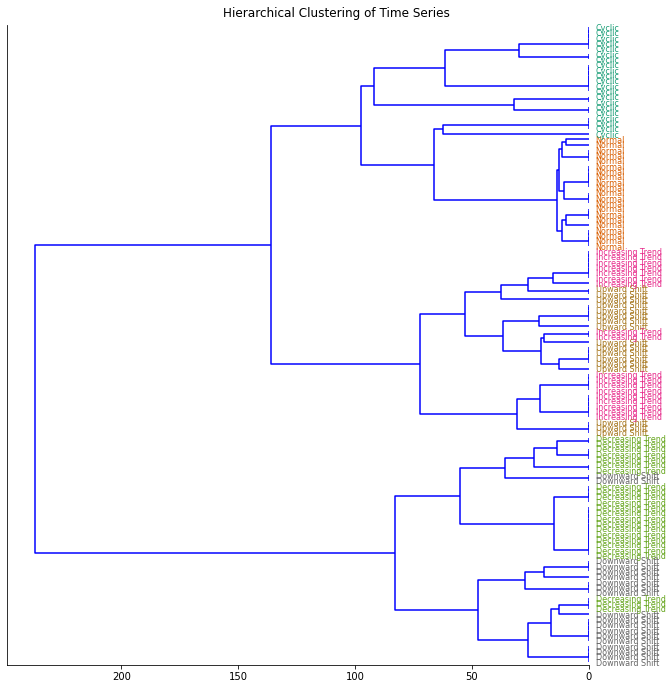

In [76]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from copy import copy
import matplotlib.image as mpimg

hierarchy.set_link_color_palette(['b'])

labels = list(X_test['Class'])
p = len(labels)

fig, ax=plt.subplots(figsize=(10,10))
dendrogram(linkage_data,orientation='left',labels=labels,
    leaf_font_size=8.,color_threshold=240, above_threshold_color='grey',ax=ax)

xlbls = ax.get_ymajorticklabels()
i=0
for lbl in xlbls:
  val = color_num[lbl.get_text()]
  lbl.set_color(my_palette(val))
  i+=1

y_min, y_max = ax.get_ylim()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#for i, c in enumerate(figs):
 #   offset_image(ticks[i], c, ax[1])
plt.tight_layout(pad=3.08)
fig.suptitle("Hierarchical Clustering of Time Series")
plt.savefig('cluster.png')
plt.show()

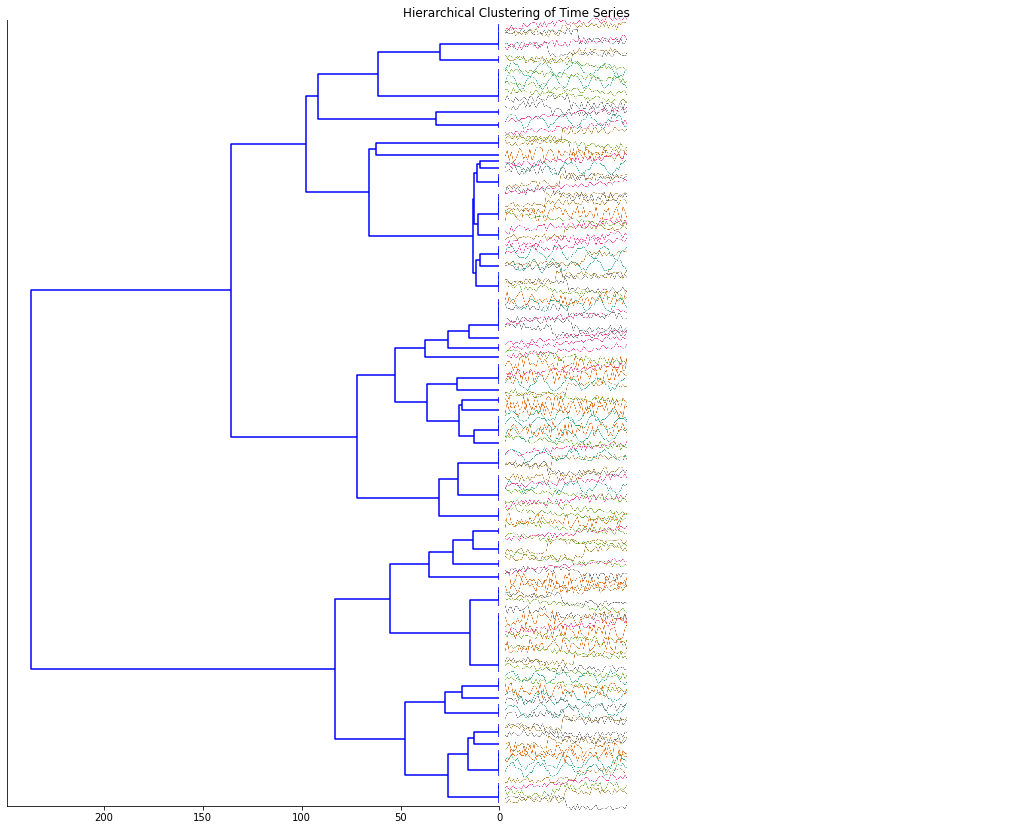

In [77]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from copy import copy
import matplotlib.image as mpimg

hierarchy.set_link_color_palette(['b'])

labels = ['' for _ in X_test['Class']]
p = len(labels)

fig, ax=plt.subplots(1,2,figsize=(15,12))
dendrogram(linkage_data,orientation='left',labels=labels,
    leaf_font_size=8.,color_threshold=240, above_threshold_color='grey',ax=ax[0])

#xlbls = ax[0].get_ymajorticklabels()
#i=0
#for lbl in xlbls:
  #val = color_num[lbl.get_text()]
  #lbl.set_color(my_palette(val))
  #i+=1

y_min, y_max = ax[0].get_ylim()
ticks = [(tick - y_min)/(y_max - y_min) for tick in ax[0].get_yticks()]
ax[1].set_yticks(ticks)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].tick_params(axis='y', which='major', pad=26,length=0)
ax[1].tick_params(axis='x', which='major', pad=26,length=0)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for i, c in enumerate(figs):
    offset_image(ticks[i], c, ax[1])
plt.tight_layout(pad=3.08)
fig.suptitle("Hierarchical Clustering of Time Series")
plt.savefig('cluster.png')
plt.show()